In [1]:
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from datasets import load_dataset
# This one is for paraphrasing
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

c:\Users\vmpletsos\Anaconda3\envs\guide\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.backends.cuda.matmul.allow_tf32 = True

In [3]:
tokenizer = AutoTokenizer.from_pretrained("prithivida/parrot_paraphraser_on_T5")
model = AutoModelForSeq2SeqLM.from_pretrained("prithivida/parrot_paraphraser_on_T5")

In [4]:
model.to('cuda');

In [5]:
dataset = load_dataset("csv", data_files='./Paraphraser Train.csv')
dataset = dataset['train']

Found cached dataset csv (C:/Users/vmpletsos/.cache/huggingface/datasets/csv/default-27dca81a434ea303/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 166.67it/s]


In [11]:
epochs = 20
max_length = 1026
task_prefix = "paraphrase: "
batch_size = 32
gradient_accumulations_steps = 0

In [12]:
# get 2 instructions from the dataset
questions = ['How to maintain marble with cracks?']
question_inputs = tokenizer([task_prefix + question for question in questions], return_tensors="pt", padding=True)
question_inputs = question_inputs.to('cuda')

preds = model.generate(
              question_inputs['input_ids'],
              do_sample=False, 
              max_length=max_length, 
              num_beams = 16,
              num_beam_groups = 4,
              diversity_penalty = 4.0,
              early_stopping=True,
              num_return_sequences=4
              )

predicted_answers = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print('Before training:')
predicted_answers

Before training:


['How do you maintain marble with cracks?',
 'How do I maintain marble with cracks?',
 'Tell me the best way to maintain marble with cracks?',
 'How do I keep marble from cracking?']

In [13]:
dataset_length = len(dataset)

In [14]:
optimizer = optim.Adam(
            params=model.parameters(),
            lr=1e-5,
            betas=(0.9, 0.999),
            eps=1e-08,
            amsgrad=False,
            weight_decay=1e-5
        )

In [15]:
losses = []
for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    epoch_loss = 0
    j = 0
    while j < dataset_length:
        if j + batch_size > dataset_length:
            originals = dataset[j:len(dataset)]['original']
            paraphrases = dataset[j:len(dataset)]['paraphrase']
        else:
            originals = dataset[j:j + batch_size]['original']
            paraphrases = dataset[j:j + batch_size]['paraphrase']
        j += batch_size 
        
        encoding = tokenizer(
            [task_prefix + original for original in originals],
            padding="longest",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
        
        target_encoding = tokenizer(
            paraphrases,
            padding="longest",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )
        labels = target_encoding.input_ids
        # replace padding token id's of the labels by -100 so it's ignored by the loss
        labels[labels == tokenizer.pad_token_id] = -100
        
        # Zero the gradients
        optimizer.zero_grad()
        
        input_ids = input_ids.to('cuda')
        attention_mask = attention_mask.to('cuda')
        labels = labels.to('cuda')
        
        # forward pass
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
        epoch_loss += loss.item()
        loss.backward()
        # (loss / gradient_accumulations_steps).backward()
        
        optimizer.step()
        # # Backward pass and optimization step
        # if (j+1) % gradient_accumulations_steps == 0:
        #     model.zero_grad()
    print('Epoch', epoch+1, 'Loss/train', epoch_loss/dataset_length)
    losses.append(epoch_loss/dataset_length)
    

Epoch 1 Loss/train 0.04625360091127942
Epoch 2 Loss/train 0.04527486568719298
Epoch 3 Loss/train 0.042889488402323504
Epoch 4 Loss/train 0.04266268763709907
Epoch 5 Loss/train 0.0413093147565372
Epoch 6 Loss/train 0.03968134177989097
Epoch 7 Loss/train 0.03821538051768164
Epoch 8 Loss/train 0.0389543532127112
Epoch 9 Loss/train 0.037366171578067035
Epoch 10 Loss/train 0.03633729986209965
Epoch 11 Loss/train 0.03596537167103446
Epoch 12 Loss/train 0.03590637984587319
Epoch 13 Loss/train 0.03528127059265597
Epoch 14 Loss/train 0.03423632718809885
Epoch 15 Loss/train 0.033991937661290765
Epoch 16 Loss/train 0.03323554243873711
Epoch 17 Loss/train 0.03306422071840296
Epoch 18 Loss/train 0.03177838469270486
Epoch 19 Loss/train 0.03191896748902211
Epoch 20 Loss/train 0.031222156843348364


In [16]:
# get 2 instructions from the dataset
questions = ['How to maintain marble with cracks?']
question_inputs = tokenizer([task_prefix + question for question in questions], return_tensors="pt", padding=True)
question_inputs = question_inputs.to('cuda')

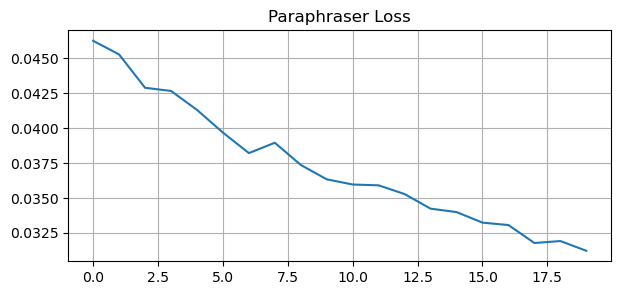

In [17]:
plt.figure(figsize=(7,3))
plt.title('Paraphraser Loss')
plt.plot(losses)
plt.grid()

In [18]:
preds = model.generate(
              question_inputs['input_ids'],
              do_sample=False, 
              max_length=max_length, 
              num_beams = 16,
              num_beam_groups = 4,
              diversity_penalty = 4.0,
              early_stopping=True,
              num_return_sequences=4
              )

In [19]:
predicted_answers = tokenizer.batch_decode(preds, skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [20]:
predicted_answers

['How to maintain marble with cracks?',
 'How to keep marble with cracks?',
 'How to repair marble with cracks?',
 'How do you repair marble with cracks?']

In [23]:
tokenizer.save_pretrained('./FineTunedParrotParaphraser');
model.save_pretrained('./FineTunedParrotParaphraser');